# Latent Semantic Indexing on Wikipedia Articles
This noteboook is meant to show the application of latent semantic indexing in a real world setting by using Wikipedia articles. Of course, this is not perfect and other steps could be optimised / polished such as the parsing.

## Creating a corpus
Since we analyze Wikipedia articles we need to convert them to a clean form of text. Thus, this method is used to exactly that.

In [1]:
import re
import requests
import pandas as pd
from bs4 import BeautifulSoup

# suppress warning of get_feature_names() being removed in sklearn 1.2
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

def getWikiArticle(name):
    # get html from web and pass it to soup parser
    url = f"https://en.wikipedia.org/wiki/{name}"
    html = requests.get(url).text
    soup = BeautifulSoup(html, features="html.parser")

    # get introduction paragraph
    whole_article = soup.find("div", {"id": "mw-content-text"})
    for p in whole_article.find_all("p"):
        if len(p.get_text().strip()) > 0:
            break
    introduction = p.get_text().lower()

    # remove references
    introduction = re.sub(r"\[.*\]", "", introduction)
    
    # remove unnecessary whitespaces
    introduction = re.sub(r"\s+", " ", introduction)

    return introduction.strip()


We use seven different articles:
- [Artificial Intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence)
- [Natural Language Processing](https://en.wikipedia.org/wiki/Natural_language_processing)
- [Information Retrieval](https://en.wikipedia.org/wiki/Information_retrieval)
- [Latent Semantic Indexing](https://en.wikipedia.org/wiki/Latent_semantic_analysis) (also known as Analysis under Wikipedia)
- [Basketball](https://en.wikipedia.org/wiki/Basketball)
- [Soccer](https://en.wikipedia.org/wiki/Soccer)
- [Handball](https://en.wikipedia.org/wiki/Handball)

In [2]:
articles = ["Artificial_intelligence", "Natural_language_processing", "Information_retrieval", "Latent_semantic_analysis",
            "Basketball", "Soccer", "Handball"]
df = pd.DataFrame(columns=["url"], data=articles)
df["text"] = df["url"].apply(getWikiArticle)
df

,url,text
0,Artificial_intelligence,artificial intelligence (ai) is intelligence—p...
1,Natural_language_processing,natural language processing (nlp) is an interd...
2,Information_retrieval,information retrieval (ir) in computing and in...
3,Latent_semantic_analysis,latent semantic analysis (lsa) is a technique ...
4,Basketball,"basketball is a team sport in which two teams,..."
5,Soccer,"association football, more commonly known as f..."
6,Handball,"handball (also known as team handball, europea..."


## Analysis of the corpus
First, we get the tf-idf values for our corpus.

In [3]:
# use library to create sparse tf_idf vectors for the corpus
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
tf_idf = vectorizer.fit_transform(df["text"])

# terms in corpus
print(len(vectorizer.get_feature_names_out()), vectorizer.get_feature_names_out())

308 ['048', '10', '11', '18', '200', '24', '250', '30', '45', '46', '90', 'accurately', 'active', 'additional', 'after', 'ai', 'aim', 'also', 'among', 'amounts', 'an', 'analysis', 'analyze', 'analyzing', 'and', 'animals', 'another', 'any', 'approximately', 'are', 'around', 'artificial', 'as', 'association', 'assumes', 'at', 'backboard', 'ball', 'based', 'basket', 'basketball', 'be', 'been', 'behind', 'between', 'beyond', 'but', 'by', 'called', 'can', 'capable', 'categorize', 'close', 'cm', 'collection', 'columns', 'commonly', 'compared', 'compete', 'computer', 'computers', 'computing', 'concepts', 'concerned', 'considered', 'consists', 'constructed', 'contain', 'contained', 'containing', 'content', 'contents', 'contextual', 'cosine', 'countries', 'counts', 'court', 'data', 'databases', 'decomposition', 'defended', 'defender', 'demonstrated', 'describes', 'designated', 'diameter', 'displayed', 'dissimilar', 'distributional', 'document', 'documents', 'done', 'each', 'end', 'estimated', '

Now we convert the results into the form we need.

In [4]:
import numpy as np
np.set_printoptions(precision=3)

# get array from sklearn
tf_idf_array = tf_idf.toarray()

# transpose result so that we get a term/document matrix instead of a document/term matrix
term_doc_matrix = tf_idf_array.T
term_doc_matrix.shape, term_doc_matrix

((308, 7),
 array([[0.   , 0.   , 0.   , ..., 0.071, 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.071, 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.099, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.099, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.143, 0.   , 0.   ]]))

We apply the singular value decomposition from the lecture.

In [5]:
# singular value decomposition
(k, sv, dr) = np.linalg.svd(term_doc_matrix, full_matrices=False)

# reshape matrices to fit each other
m, n = term_doc_matrix.shape
k = k[:, :n]
d = dr[:m, :]

# make "sv" a matrix of appropriate shape
s = np.diag(sv)

In [6]:
# reconstruction of original matrix
reconstructed_term_doc_matrix = (k @ s @ d)

print("Is roughly the same?")
print(np.allclose(term_doc_matrix, reconstructed_term_doc_matrix))
reconstructed_term_doc_matrix.round(5)

Is roughly the same?
True


array([[-0.   ,  0.   , -0.   , ...,  0.071,  0.   , -0.   ],
       [-0.   ,  0.   ,  0.   , ...,  0.071,  0.   ,  0.   ],
       [ 0.   ,  0.   , -0.   , ...,  0.   ,  0.099,  0.   ],
       ...,
       [ 0.   ,  0.   , -0.   , ...,  0.   , -0.   , -0.   ],
       [ 0.   ,  0.   , -0.   , ...,  0.   ,  0.099,  0.   ],
       [-0.   ,  0.   , -0.   , ...,  0.143,  0.   ,  0.   ]])

Now we apply the rank reduction and create the according latent spaces.

In [7]:
ss = sv.copy()
ss[2:] = 0
ss = np.diag(ss)
ss

array([[1.473, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 1.052, 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]])

Reduced matrix `ms`.

In [8]:
ms = k @ ss @ d
ms.round(5)

array([[-0.007,  0.004,  0.001, ...,  0.022,  0.023,  0.022],
       [-0.007,  0.004,  0.001, ...,  0.022,  0.023,  0.022],
       [-0.009,  0.007,  0.002, ...,  0.032,  0.033,  0.032],
       ...,
       [ 0.036,  0.039,  0.032, ...,  0.004,  0.005,  0.003],
       [-0.009,  0.007,  0.002, ...,  0.032,  0.033,  0.032],
       [-0.014,  0.009,  0.002, ...,  0.044,  0.046,  0.044]])

Create term and document space.

In [9]:
ts = k @ ss
ds = ss @ d

print("Terms in topic space")
print(ts.round(2))

print("\nDocuments in topic space")
print(ds.round(2))

Terms in topic space
[[-0.03  0.03  0.   ...  0.    0.    0.  ]
 [-0.03  0.03  0.   ...  0.    0.    0.  ]
 [-0.04  0.04  0.   ...  0.    0.    0.  ]
 ...
 [-0.05 -0.05  0.   ...  0.    0.    0.  ]
 [-0.04  0.04  0.   ...  0.    0.    0.  ]
 [-0.06  0.05  0.   ...  0.    0.    0.  ]]

Documents in topic space
[[-0.33 -0.66 -0.47 -0.51 -0.6  -0.65 -0.6 ]
 [-0.55 -0.35 -0.34 -0.33  0.39  0.39  0.4 ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]]


Previewing the similarity of documents.

In [10]:
%matplotlib inline

import matplotlib.pyplot as plt

From linear algebra, the dot product of row i with row j is the i,j th entry of AA<sup>T</sup>. Similarly, the dot product of column i with column j is the i,j th entry of (A<sup>T</sup>)A.

In [11]:
raw_similarities = term_doc_matrix.T @ term_doc_matrix
raw_similarities

array([[1.   , 0.229, 0.106, 0.098, 0.049, 0.093, 0.082],
       [0.229, 1.   , 0.251, 0.298, 0.235, 0.243, 0.208],
       [0.106, 0.251, 1.   , 0.175, 0.137, 0.143, 0.142],
       [0.098, 0.298, 0.175, 1.   , 0.158, 0.158, 0.138],
       [0.049, 0.235, 0.137, 0.158, 1.   , 0.341, 0.283],
       [0.093, 0.243, 0.143, 0.158, 0.341, 1.   , 0.359],
       [0.082, 0.208, 0.142, 0.138, 0.283, 0.359, 1.   ]])

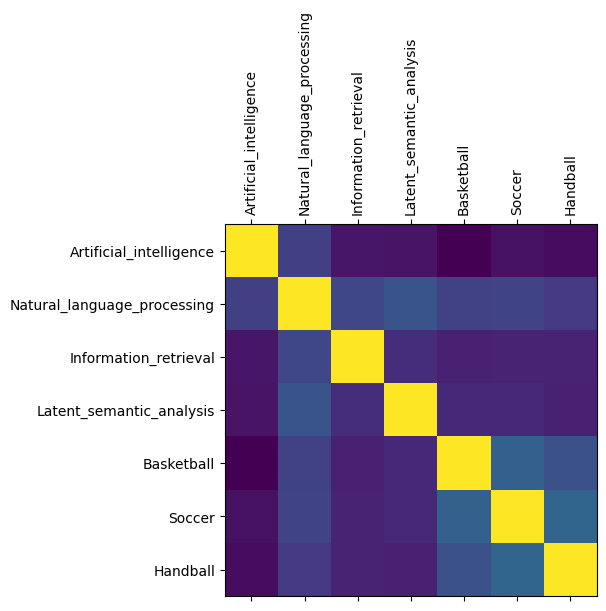

In [12]:
plt.matshow(raw_similarities)

# set labels on axis
_ = plt.xticks(range(len(articles)), articles, rotation=90)
_ = plt.yticks(range(len(articles)), articles)

In [13]:
lsi_similarities = ms.T @ ms
lsi_similarities

array([[ 0.408,  0.407,  0.339,  0.349, -0.012,  0.002, -0.017],
       [ 0.407,  0.551,  0.425,  0.447,  0.262,  0.291,  0.258],
       [ 0.339,  0.425,  0.333,  0.349,  0.153,  0.173,  0.149],
       [ 0.349,  0.447,  0.349,  0.366,  0.176,  0.198,  0.172],
       [-0.012,  0.262,  0.153,  0.176,  0.518,  0.547,  0.521],
       [ 0.002,  0.291,  0.173,  0.198,  0.547,  0.578,  0.549],
       [-0.017,  0.258,  0.149,  0.172,  0.521,  0.549,  0.523]])

Similarities of the documents:
the brighter the more similar

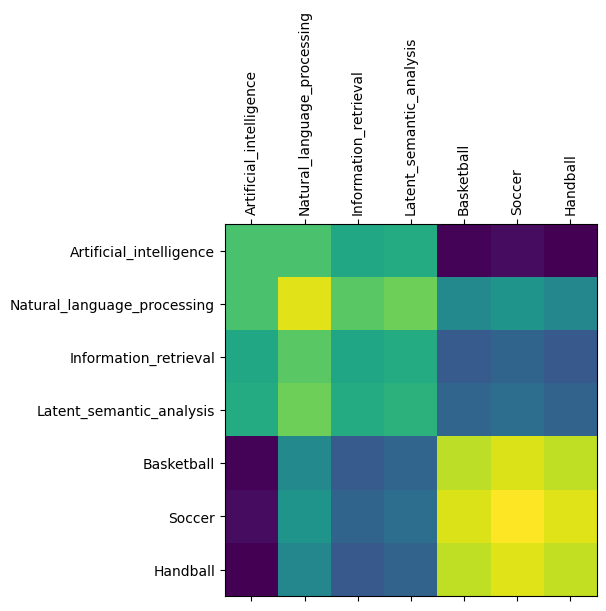

In [14]:
plt.matshow(lsi_similarities)

# set labels on axis
_ = plt.xticks(range(len(articles)), articles, rotation=90)
_ = plt.yticks(range(len(articles)), articles)

## Visualising the results

(-1.2, 2.2, -1.2, 1.2)

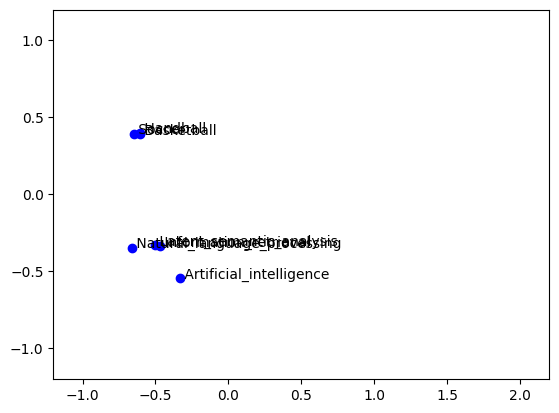

In [15]:
# prepare data
t1 = ts[:,0] # term x-axis values
t2 = ts[:,1] # term y-axis values

d1 = ds[0,:] # document x-axis values
d2 = ds[1,:] # document y-axis values

# init plot boilerplate
fig = plt.figure()
ax = fig.add_subplot(111)

# plot and label terms for terms --> it's a lot so i advise against plotting it
#plt.plot(t1, t2, 'r+')
#for i, txt in enumerate(ts[:,0]):
#    ax.annotate(f" term {str(i)}", (t1[i],t2[i]))

# plot an label documents for documents
plt.plot(d1, d2, 'bo')
for i, url in enumerate(df["url"]):
    ax.annotate(f" {url}", (d1[i],d2[i]))

# axis
plt.axis([-1.2, 2.2, -1.2, 1.2])
# fig.savefig("lsi_wiki.pdf")

LSI may not be perfect but this shows a good result for it!
- Computer science related topics are close to each other (+)
- Team sports are very close to each other (++)